In [1]:
import timeit

import math
import fiona
import numpy as np
import osmnx as ox
import pandas as pd
import networkx as nx
import geopandas as gp
import matplotlib.pyplot as plt

from random import random
from queue import PriorityQueue
from shapely.ops import nearest_points
from shapely.geometry import Polygon,Point, MultiPoint, box
from skgeom import Point2,Segment2,arrangement,intersection,RotationalSweepVisibility, draw

%matplotlib inline

np.random.seed(2021)

In [2]:
from QDalgo import QDkMaximumVisibility
from QValgo import QVkMaximumVisibility
from TDalgo import TDkMaximumVisibility

from helpers import *

In [3]:
gdf = gp.read_file("obstacles2000.gpkg")
qpGdf = gp.read_file("querypoints2000.gpkg")

In [4]:

'''
    Visibility skgeom construction
'''
minx, miny, maxx, maxy = qpGdf.total_bounds*10000
minx-=10
miny-=10
maxx+=10
maxy+=10
outer = [
    Segment2(Point2(minx,miny), Point2(minx,maxy)), Segment2(Point2(minx,maxy), Point2(maxx,maxy)),
    Segment2(Point2(maxx,maxy), Point2(maxx,miny)), Segment2(Point2(maxx,miny), Point2(minx,miny))
]
arr = arrangement.Arrangement()

for bounds in outer:
    arr.insert(bounds)

Boundary = Polygon([(minx,miny),(minx,maxy),(maxx,maxy),(maxx,miny)])


In [5]:
'''
    Preprocessing our obstacle GeoDataFrame

        1. Simplifying building geometries
        2. Adding centroids
        x. Removing some obstacles randomly (not for prod?)
'''

# envelope : convert to rectangles, simplify: reduce edges (also see shapely/geopandas docs)
simple = gdf['geometry'].convex_hull # REMOVING HOLES
simple = simple.simplify(0.5) # EDGE REDUCTION

# simple = gdf['geometry'].simplify(0.5) 
# simple = gdf['geometry'].envelope # RECTANGLE APPROXIMATION ORIENTED WITH THE AXES
gdf['geometry'] = simple

# gdf = gdf.set_crs("EPSG:3035", allow_override=True)
gdf['centroid'] = gdf.centroid

gdf = gdf.sample(frac=0.3)
print(gdf.shape)

(2516, 143)


In [6]:
'''
    Building TARGET.
'''
# Random Target
Target = gdf.sample(n=1)

# Specific Target
# Target = gdf.loc[gdf['name'] == 'Museum of Contemporary Art'] # comment frac.
print(Target)

gdf.drop(Target.index, inplace=True)

     element_type      osmid addr:state    building    ele gnis:county_name  \
1596          way  425668497       None  apartments  168.6             None   

     gnis:feature_id gnis:import_uuid gnis:reviewed  name  ...  \
1596            None             None          None  None  ...   

     building:levels:underground  ways  type   url building:height capacity  \
1596                        None  None  None  None            None     None   

     theatre:genre name:de                                           geometry  \
1596          None    None  POLYGON ((-118.24808 34.06965, -118.24846 34.0...   

                         centroid  
1596  POINT (-118.24824 34.06977)  

[1 rows x 143 columns]


In [7]:
'''
    Inserting Target in our arrangement
'''
targetVx = Target.geometry.exterior.iloc[0].coords
targetBuilder = []

# [TODO] Build a duplicate checker since skgeom throws an error
for i in range(len(targetVx)-1):
    targetBuilder.append(Segment2(Point2(targetVx[i][0]*10000,targetVx[i][1]*10000), Point2(targetVx[i+1][0]*10000,targetVx[i+1][1]*10000)))

for bounds in targetBuilder:
    arr.insert(bounds)

targetPolyBuilder = []
for i in range(len(targetVx)-1):
    targetPolyBuilder.append(Point(targetVx[i][0]*10000,targetVx[i][1]*10000))

scaledTarget = Polygon(targetPolyBuilder)

In [8]:
treeNodes = []
for rtn in gdf.sindex.leaves():
    for rt in rtn[1]:
        treeNodes.append(rt)

Phase 1 OK!
Phase 1 OK!
Time:  16.680105196001023
[19, 18, 23, 22, 21]
[1.658902, 1.082177, 0, 0, 0]


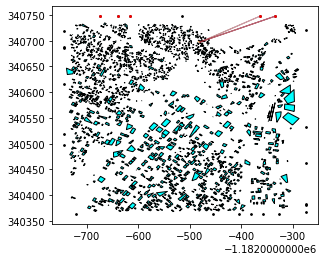

In [9]:
start = timeit.default_timer()
ans, ans_vis, ans_vrPoly, vrPolygons = QDkMaximumVisibility(targetBuilder, qpGdf, 5, gdf,Boundary,arr,treeNodes)
ans, ans_vis, ans_vrPoly, vrPolygons = QDkMaximumVisibility(targetBuilder, qpGdf, 5, gdf,Boundary,arr,treeNodes)
stop = timeit.default_timer()
print('Time: ', stop - start)
print(list(ans))
print(list(ans_vis))

plotFinal(scaledTarget,gdf.sindex,gdf,qpGdf,vrPolygons,ans_vrPoly,ans)

Phase 1 OK!
Phase 1 OK!
Time:  11.000599663000685
[19, 18, 23, 22, 21]
[1.658902, 1.082177, 0, 0, 0]


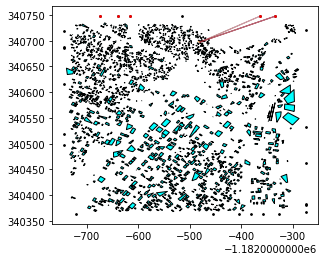

In [10]:
start = timeit.default_timer()
ans, ans_vis, ans_vrPoly, vrPolygons = QVkMaximumVisibility(targetBuilder, qpGdf, 5, gdf,Boundary,arr,treeNodes)
ans, ans_vis, ans_vrPoly, vrPolygons = QVkMaximumVisibility(targetBuilder, qpGdf, 5, gdf,Boundary,arr,treeNodes)
stop = timeit.default_timer()
print('Time: ', stop - start)
print(list(ans))
print(list(ans_vis))

plotFinal(scaledTarget,gdf.sindex,gdf,qpGdf,vrPolygons,ans_vrPoly,ans)

Phase 1 OK!
Phase 1 OK!
Time:  13.59654989199953
[19, 18, 23, 22, 21]
[1.658902, 1.082177, 0, 0, 0]


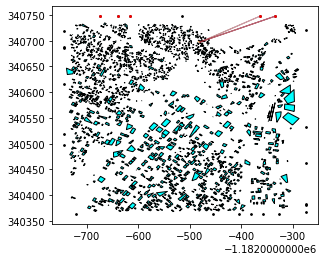

In [11]:
start = timeit.default_timer()
ans, ans_vis, ans_vrPoly, vrPolygons = TDkMaximumVisibility(targetBuilder, qpGdf, 5, gdf,scaledTarget,Boundary,arr)
ans, ans_vis, ans_vrPoly, vrPolygons = TDkMaximumVisibility(targetBuilder, qpGdf, 5, gdf,scaledTarget,Boundary,arr)
stop = timeit.default_timer()
print('Time: ', stop - start)
print(list(ans))
print(list(ans_vis))

plotFinal(scaledTarget,gdf.sindex,gdf,qpGdf,vrPolygons,ans_vrPoly,ans)